In [105]:
pip install gensim


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [106]:
import pandas as pd

# CSV 파일 불러오기
df = pd.read_csv("/Users/matthew941/Desktop/KORE208_team5/3. 정치인별 빈도, 워드임베딩/3. 이준석/lee_junseok_tagged_filtered_ver2.csv")

In [107]:
import re

tokenized_sentences = [
    [token for token in sentence.split() if token.split("(")[0].lower() != "vs"]
    for sentence in df['tagged'].dropna()
]

In [108]:
from gensim.models import Word2Vec

# 형태소 분석된 문장에서 단어만 추출 (ex: '라디오(NNG)' → '라디오') + 'vs' 삭제
sentences = df['tagged'].dropna().tolist()

# 제외하고 싶은 단어
ban_words = {"vs", "였고", "D", "이", "엿새", "보름", "열흘", "연이틀", "뉴시스","후보","깨"}
ban_tags = {"VCP", "SL"}

# 필터링
tokenized_sentences = [
    [
        token.split('(')[0]
        for token in sentence.split()
        if token.split('(')[0].lower() not in ban_words and token.split('(')[-1][:-1] not in ban_tags
    ]
    for sentence in sentences
]


# Word2Vec 학습 (Skip-gram, sg=1)
model = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=100,
    window=5,
    min_count=3,
    sg=1,
    workers=4,
    seed=42
)

# Word2Vec에 실제 들어간 단어만 기준으로 딕셔너리 생성
word_to_tag = {}

for sentence in df['tagged'].dropna():
    for token in sentence.split():
        if "(" in token and ")" in token:
            word, tag = token.rsplit("(", 1)
            tag = tag.rstrip(")")
            # 단어가 Word2Vec 학습에 실제 포함된 경우만
            if word in model.wv and word not in word_to_tag:
                word_to_tag[word] = tag



# 이준석과 유사한 단어 50개 추출

keyword = '이준석'

if keyword in model.wv:
    similar_words = model.wv.most_similar(keyword, topn=50)
    print(f"\n[{keyword}]과 유사한 단어 (품사 포함):")
    for word, sim in similar_words:
        tag = word_to_tag.get(word, "UNKNOWN")  # 품사 없으면 'UNKNOWN'으로 출력
        print(f"  {word} ({tag}) - {sim:.3f}")
else:
    print(f"'{keyword}' 단어가 Word2Vec vocabulary에 없습니다.")




[이준석]과 유사한 단어 (품사 포함):
  순서 (NNG) - 0.637
  시작점 (NNG) - 0.636
  아류 (NNG) - 0.633
  휩싸이 (VV) - 0.629
  개혁신당 (NNP) - 0.629
  한판 (NNG) - 0.619
  다자 (NNG) - 0.618
  선명히 (MAG) - 0.616
  기쁘 (VA) - 0.614
  도장 (NNG) - 0.613
  이외 (NNG) - 0.613
  간소 (NNG) - 0.612
  충청남도청 (NNP) - 0.610
  3파전 (NNG) - 0.610
  삼자 (NNG) - 0.610
  하락세 (NNG) - 0.608
  동반 (NNG) - 0.606
  캐스팅 (NNG) - 0.600
  기형 (NNG) - 0.600
  관전 (NNG) - 0.600
  오른쪽 (NNG) - 0.600
  거절 (NNG) - 0.599
  종일 (NNG) - 0.599
  난타전 (NNG) - 0.599
  진검 (NNG) - 0.598
  남소연 (NNP) - 0.597
  면담 (NNG) - 0.597
  맞붙 (VV) - 0.596
  호응 (NNG) - 0.595
  앞줄 (NNG) - 0.594
  필패 (NNG) - 0.594
  프레스센터 (NNP) - 0.594
  대구광역시 (NNP) - 0.592
  3자 (NNG) - 0.592
  찢어지 (VV) - 0.591
  연일 (MAG) - 0.591
  화면 (NNG) - 0.590
  머무르 (VV) - 0.587
  몸값 (NNG) - 0.587
  패싱 (NNP) - 0.587
  대체로 (MAG) - 0.587
  상관없이 (MAG) - 0.586
  기정사실 (NNG) - 0.586
  재차 (MAG) - 0.586
  여전 (XR) - 0.586
  고무 (NNG) - 0.585
  결장 (NNG) - 0.584
  양자대결 (NNP) - 0.583
  권영길 (NNP) - 0.583
  승부 (NNG) - 0.582


zsh:1: command not found: pip
zsh:1: command not found: pip


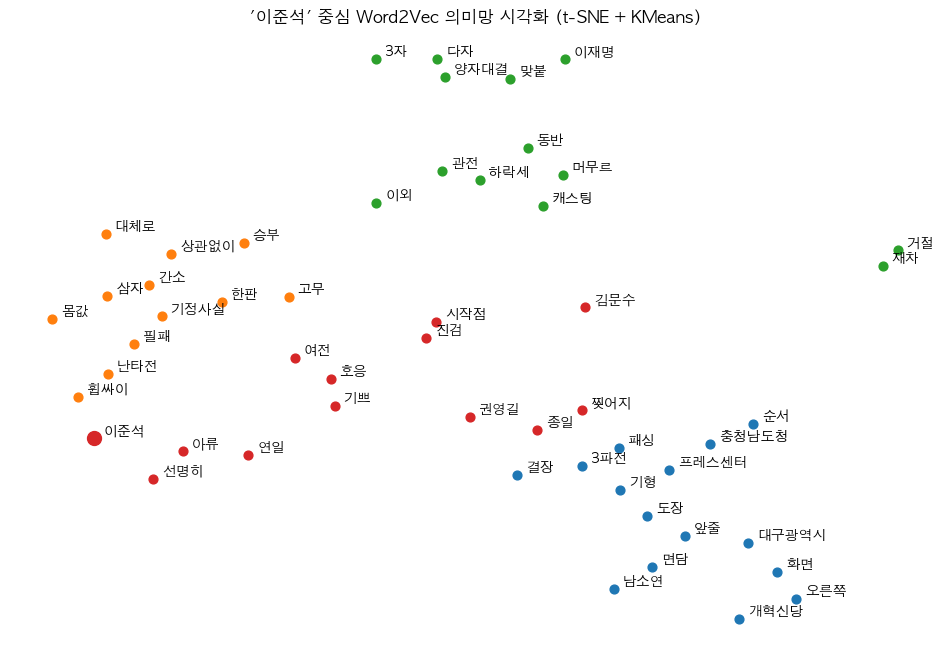

In [109]:
# 2D

import numpy as np

!pip install scikit-learn
!pip install matplotlib

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib as mpl
import platform

# 폰트 지정
# mpl.rcParams['font.family'] = 'Malgun Gothic'
# mpl.rcParams['axes.unicode_minus'] = False

# macOS인 경우 한글 폰트 설정
if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'

# 유사 단어 50개
similar_tuples = model.wv.most_similar(keyword, topn=50)
similar_words = [keyword] + [word for word, _ in similar_tuples]

# 필수 단어 포함
must_include = ['이재명', '김문수']
for word in must_include:
    if word not in similar_words and word in model.wv:
        similar_words.append(word)

# 벡터 추출
word_vectors = np.array([model.wv[word] for word in similar_words])

# t-SNE 차원 축소 (★ n_iter 제거함!)
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
vec_2d = tsne.fit_transform(word_vectors)

# KMeans 클러스터링
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(vec_2d)

# 시각화
plt.figure(figsize=(12, 8))
for i, word in enumerate(similar_words):
    x, y = vec_2d[i]
    plt.scatter(x, y, c=f"C{labels[i]}", s=100 if word == keyword else 40)
    plt.text(x + 0.5, y + 0.5, word, fontsize=10)
plt.title(f"'{keyword}' 중심 Word2Vec 의미망 시각화 (t-SNE + KMeans)")
plt.axis('off')
plt.show()

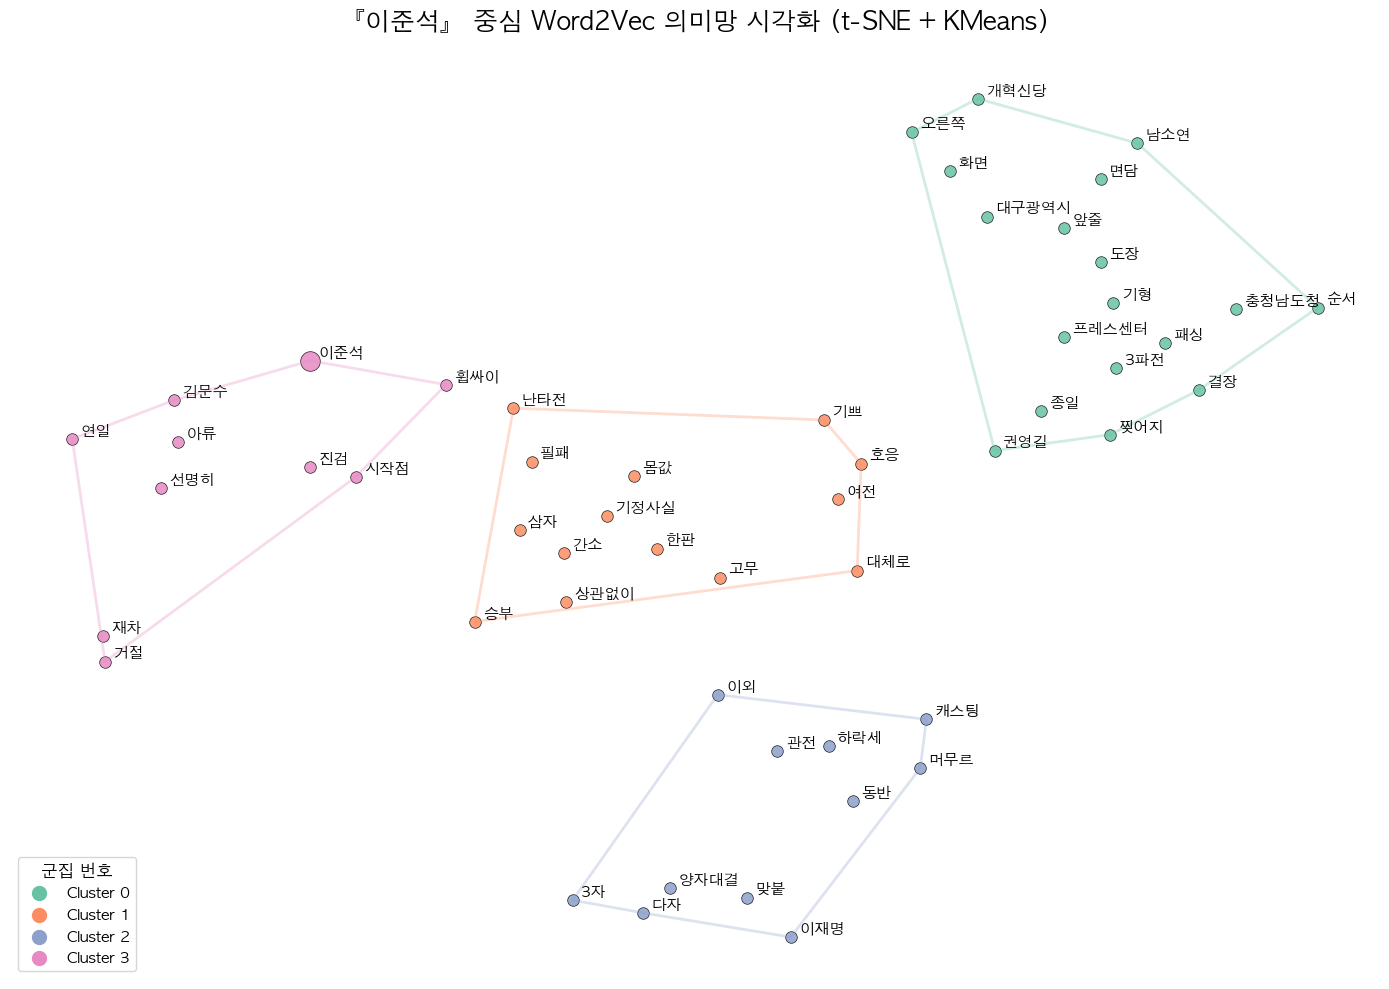

In [123]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import seaborn as sns
import platform

# 중심 단어 설정
keyword = '이준석'

# 한글 폰트 설정
if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 유사 단어 50개 (top50)
similar_tuples = model.wv.most_similar(keyword, topn=50)
similar_words = [keyword] + [word for word, _ in similar_tuples]

# 필수 단어 추가
must_include = ['김문수', '이재명']
for word in must_include:
    if word not in similar_words and word in model.wv:
        similar_words.append(word)

# 벡터 추출
word_vectors = np.array([model.wv[word] for word in similar_words])

# 차원 축소
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
vec_2d = tsne.fit_transform(word_vectors)

# KMeans 클러스터링
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(vec_2d)

# 색상 팔레트
palette = sns.color_palette("Set2", n_colors=4)

# 시각화 시작
plt.figure(figsize=(14, 10))
plt.title(f"『{keyword}』 중심 Word2Vec 의미망 시각화 (t-SNE + KMeans)", fontsize=18, weight='bold', pad=20)

# Convex Hull로 클러스터 영역 그리기
for label in np.unique(labels):
    cluster_points = vec_2d[labels == label]
    if len(cluster_points) >= 3:
        hull = ConvexHull(cluster_points)
        hull_vertices = np.append(hull.vertices, hull.vertices[0])  # 경계선 닫기
        plt.plot(cluster_points[hull_vertices, 0], cluster_points[hull_vertices, 1],
                 linestyle='-', linewidth=2, color=palette[label], alpha=0.3)
        # 각 클러스터 중심 좌표에 cluster 번호 텍스트 추가



# 노드 및 단어 출력
for i, word in enumerate(similar_words):
    x, y = vec_2d[i]
    size = 200 if word == keyword else 70
    weight = 'bold' if word == keyword else 'normal'
    label_color = palette[labels[i]]
    plt.scatter(x, y, c=[label_color], s=size, alpha=0.85, edgecolors='k', linewidths=0.5)
    plt.text(x + 0.4, y + 0.4, word, fontsize=11, weight=weight)

plt.axis('off')
# 범례용 사각형 색상 및 라벨 수동 생성
for label in np.unique(labels):
    plt.scatter([], [], c=[palette[label]], label=f'Cluster {label}', s=100)

# 범례 위치 왼쪽 하단으로 이동
plt.legend(title="군집 번호", loc='lower left', fontsize=11, title_fontsize=12, frameon=True)

plt.tight_layout()
plt.show()

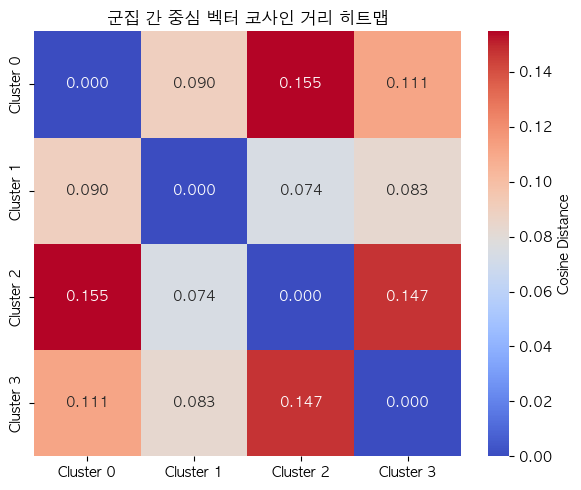

In [124]:
from sklearn.metrics.pairwise import cosine_distances
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 군집별 벡터 분리
cluster_vectors = {}
for cluster_id in range(4):
    idxs = np.where(labels == cluster_id)[0]
    cluster_vectors[cluster_id] = word_vectors[idxs]

# 군집 중심 벡터 계산
cluster_centroids = {
    cluster_id: np.mean(vectors, axis=0)
    for cluster_id, vectors in cluster_vectors.items()
}

# 코사인 거리 계산
centroid_matrix = np.array([cluster_centroids[i] for i in range(4)])
cosine_distance_matrix = cosine_distances(centroid_matrix)

# 히트맵 시각화
df_dist = pd.DataFrame(cosine_distance_matrix, 
                       index=[f'Cluster {i}' for i in range(4)], 
                       columns=[f'Cluster {i}' for i in range(4)])

plt.figure(figsize=(6, 5))
sns.heatmap(df_dist, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={"label": "Cosine Distance"})
plt.title("군집 간 중심 벡터 코사인 거리 히트맵")
plt.tight_layout()
plt.show()


In [125]:
from itertools import combinations
from scipy.spatial.distance import cosine
import numpy as np

def semantic_cohesiveness(model, keyword, topn=20):
    # 유사 단어 추출
    similar_words = [word for word, _ in model.wv.most_similar(keyword, topn=topn)]
    
    # 벡터 추출
    vectors = [model.wv[word] for word in similar_words]

    # 단어쌍 코사인 거리 평균
    word_pairs = list(combinations(range(len(vectors)), 2))
    distances = [cosine(vectors[i], vectors[j]) for i, j in word_pairs]

    avg_distance = np.mean(distances)
    print(f"『{keyword}』의 의미 결속력 (20개 유사어 간 평균 코사인 거리): {avg_distance:.4f}")
    return avg_distance

# 예시 실행
semantic_cohesiveness(model, keyword='이준석', topn=20)
semantic_cohesiveness(model, keyword='이재명', topn=20)
semantic_cohesiveness(model, keyword='김문수', topn=20)



『이준석』의 의미 결속력 (20개 유사어 간 평균 코사인 거리): 0.1907
『이재명』의 의미 결속력 (20개 유사어 간 평균 코사인 거리): 0.2039
『김문수』의 의미 결속력 (20개 유사어 간 평균 코사인 거리): 0.2968


0.2968059349948903

| 정치인     | 의미 결속력(↓)  | 해석                                                   |
| ------- | ---------- | ---------------------------------------------------- |
| **이준석** | **0.1907** | **가장 응집력 높음**. 유사 단어들끼리 매우 유사하며, 특정 담론 안에서 집중적으로 언급됨 |
| **이재명** | **0.2039** | **적당한 응집력**. 다양한 맥락에서 언급되며, 유사 단어 간 밀도도 높음           |
| **김문수** | **0.2968** | **가장 분산**. 유사 단어들 간 유사도가 낮고, 다양한 의미 공간에 퍼져 있음        |


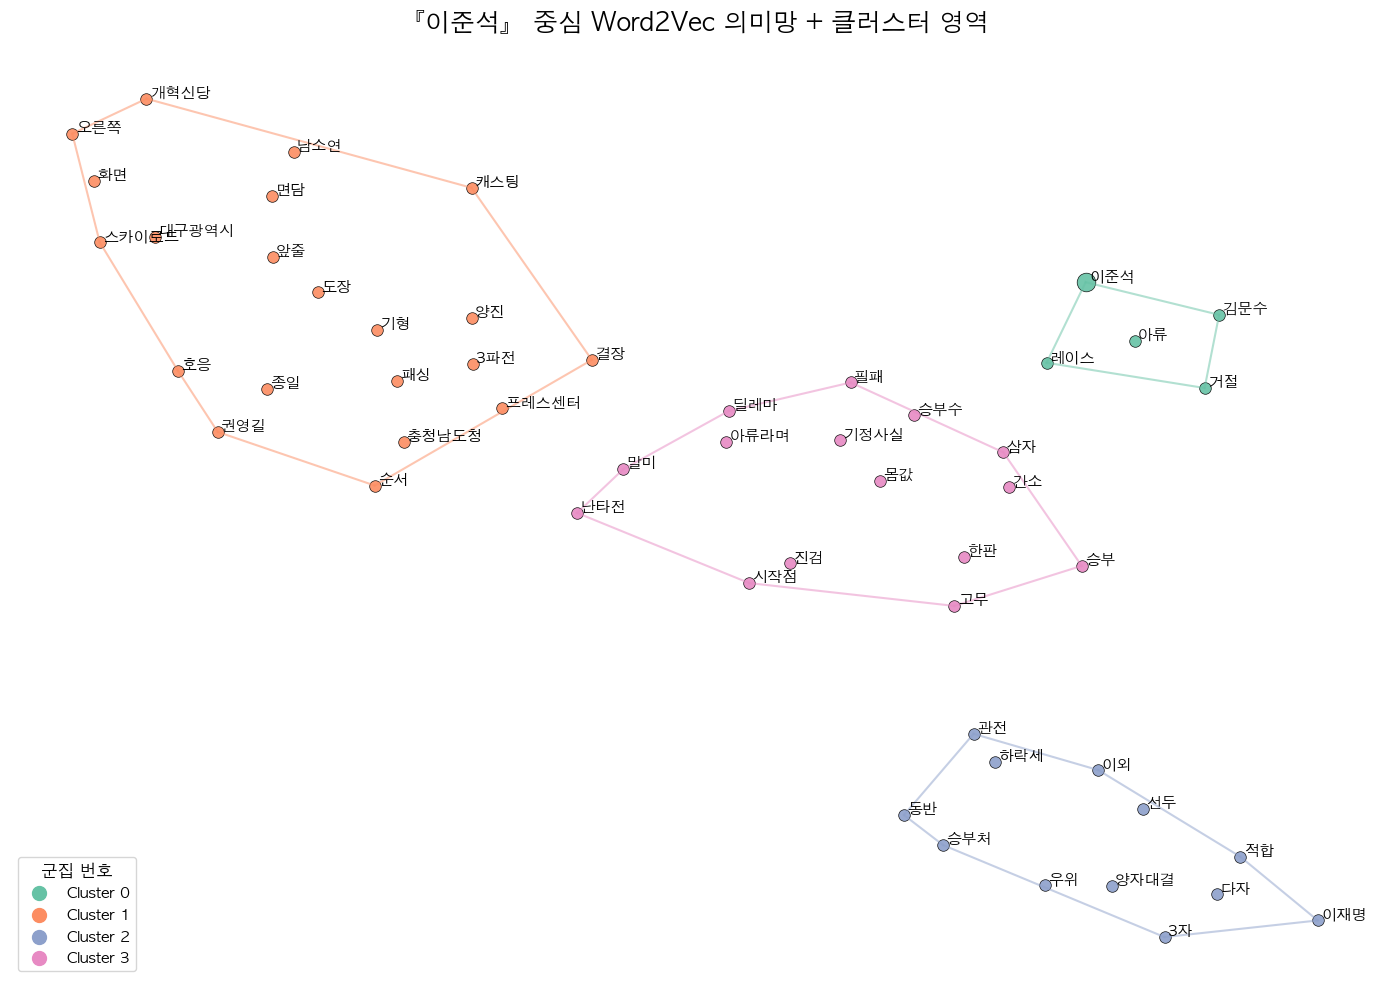

In [114]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.spatial import ConvexHull
import platform
import seaborn as sns

# 폰트 설정
if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 유사 단어 뽑기
all_similar = model.wv.most_similar(keyword, topn=500)
noun_similar = [word for word, sim in all_similar if word_to_tag.get(word, "").startswith("NN")]
similar_words = [keyword] + noun_similar[:50]
must_include = ['김문수', '이재명']
for word in must_include:
    if word not in similar_words and word in model.wv:
        similar_words.append(word)

# 벡터 추출
word_vectors = np.array([model.wv[word] for word in similar_words])

# 차원 축소 (t-SNE)
tsne = TSNE(n_components=2, perplexity=6, random_state=42)
vec_2d = tsne.fit_transform(word_vectors)

# 클러스터링 (KMeans)
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(vec_2d)

# 색상 팔레트
palette = sns.color_palette("Set2", n_colors=4)

# 시각화 시작
plt.figure(figsize=(14, 10))
plt.title(f"『{keyword}』 중심 Word2Vec 의미망 + 클러스터 영역", fontsize=18, weight='bold', pad=20)

# 군집별 Convex Hull 그리기
for label in np.unique(labels):
    points = vec_2d[labels == label]
    if len(points) >= 3:  # ConvexHull은 최소 3점 필요
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], linestyle='-', color=palette[label], alpha=0.5)

# 단어 + 점 찍기
for i, word in enumerate(similar_words):
    x, y = vec_2d[i]
    size = 180 if word == keyword else 70
    weight = 'bold' if word == keyword else 'normal'
    plt.scatter(x, y, c=[palette[labels[i]]], s=size, alpha=0.9, edgecolors='k', linewidths=0.5)
    plt.text(x + 0.3, y + 0.3, word, fontsize=11, weight=weight)

plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.box(False)
plt.axis('off')
# 범례용 사각형 색상 및 라벨 수동 생성
for label in np.unique(labels):
    plt.scatter([], [], c=[palette[label]], label=f'Cluster {label}', s=100)

# 범례 위치 왼쪽 하단으로 이동
plt.legend(title="군집 번호", loc='lower left', fontsize=11, title_fontsize=12, frameon=True)
plt.tight_layout()
plt.show()

In [112]:
pip install plotly

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [113]:
# 3D

import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import plotly.io as pio

# 🔧 브라우저로 출력되도록 설정
pio.renderers.default = "browser"

# 1. 유사 단어 추출
similar_tuples = model.wv.most_similar(keyword, topn=50)
similar_words = [keyword] + [word for word, _ in similar_tuples]
word_vectors = np.array([model.wv[word] for word in similar_words])

# 2. 3차원 t-SNE
tsne = TSNE(n_components=3, perplexity=5, random_state=42)
vec_3d = tsne.fit_transform(word_vectors)

# 3. KMeans 클러스터링
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(vec_3d)

# 4. Plotly 시각화
fig = go.Figure()

for i in range(4):
    idx = [j for j, label in enumerate(labels) if label == i]
    fig.add_trace(go.Scatter3d(
        x=vec_3d[idx, 0],
        y=vec_3d[idx, 1],
        z=vec_3d[idx, 2],
        mode='markers+text',
        marker=dict(size=[10 if similar_words[j] == keyword else 5 for j in idx]),
        text=[similar_words[j] for j in idx],
        name=f'Cluster {i+1}',
        textposition='top center'
    ))

fig.update_layout(
    title=f"'{keyword}' 중심 Word2Vec 의미망 시각화 (3D t-SNE + KMeans)",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)

fig.show()